# Master's thesis case study 0: counterfactual

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy
import torch
from adaptive_nof1 import *
from adaptive_nof1.policies import *
from adaptive_nof1.helpers import *
from adaptive_nof1.inference import *
from adaptive_nof1.metrics import *
from matplotlib import pyplot as plt
from paretoset import paretoset
import json

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Counterfactual study

In [3]:
# Setup generic n-of-1 parameters
length = 6
number_of_actions = 3
number_of_patients = (number_of_actions ** (length - number_of_actions)) * 10000

In [4]:
# In this case study, we assume a know variance of 1 and three independent variables.
# Our data generating model can therefore be expressed as a multivariate normal with \eye as the covariance matrics
class MultivariateNormal(Model):
    def __init__(self, patient_id):
        self.rng = numpy.random.default_rng(patient_id)
        self.mu = [-2, 1.8, 2]
        self.patient_id = patient_id
        self.distribution = torch.distributions.MultivariateNormal(torch.tensor(self.mu), torch.eye(len(self.mu)))

    @property
    def additional_config(self):
        return {"expectations_of_interventions": self.mu}

    @property
    def number_of_interventions(self):
        return len(self.mu)
    
    def generate_context(self, history):
        return {}

    def observe_outcome(self, intervention, context):
        return {"outcome": self.distribution.sample()[intervention["treatment"]].item()}

    def __str__(self):
        return f"MultivariateNormal {self.mu}"

data_generating_model = lambda patient_id: MultivariateNormal(patient_id)

In [5]:
from adaptive_nof1 import SeriesOfSimulationsRunner
from adaptive_nof1.policies import FixedIndexedPolicy, FrequentistEpsilonGreedy, ConstantPolicy
from adaptive_nof1.inference import NormalKnownVariance

fixed_schedule_runner = SeriesOfSimulationsRunner(
    model_from_patient_id=data_generating_model,
    n_patients=number_of_patients,
    policy=FixedIndexedPolicy(number_of_actions=number_of_actions,
                              inference=NormalKnownVariance(
                                  variance=1,
    )
    ),
)

fixed_schedule_data = fixed_schedule_runner.simulate(length)

  0%|          | 0/6 [00:00<?, ?it/s]

<Axes: xlabel='$j$', ylabel='Regret'>

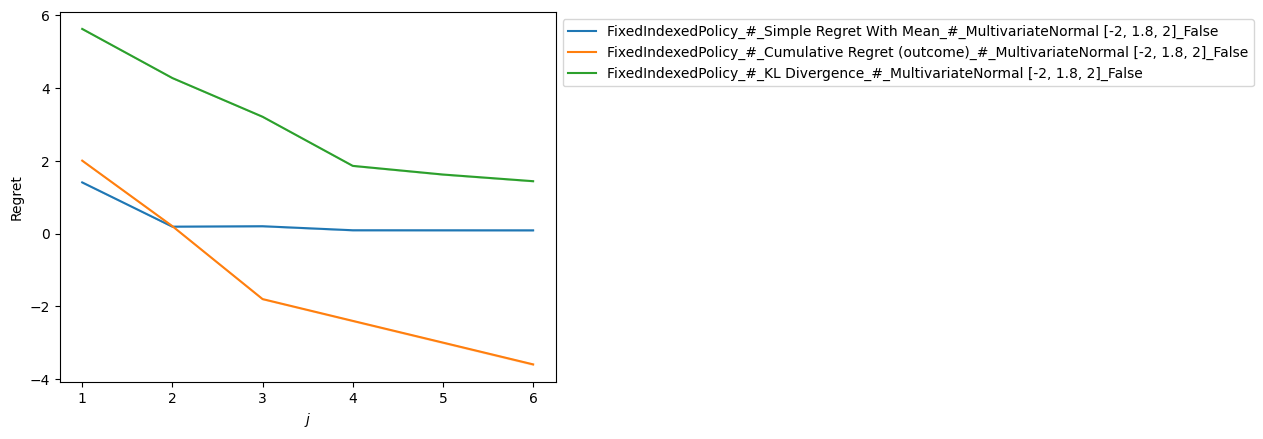

In [6]:
from adaptive_nof1.metrics import SimpleRegretWithMean, CumulativeRegret, KLDivergence
from adaptive_nof1.series_of_simulations_data import SeriesOfSimulationsData

def debug_data_to_torch_distribution(debug_data):
    mean = debug_data["mean"]
    variance = debug_data["variance"]
    cov = torch.diag_embed(torch.tensor(numpy.sqrt(variance)))
    return torch.distributions.MultivariateNormal(torch.tensor(mean), cov)

SeriesOfSimulationsData.plot_lines(
    [fixed_schedule_data],
    [
        SimpleRegretWithMean(),
        CumulativeRegret(),
        KLDivergence(data_to_true_distribution = lambda x: MultivariateNormal(0).distribution, debug_data_to_posterior_distribution=debug_data_to_torch_distribution)
    ],
    legend_position=(1,1),
)

In [8]:
from adaptive_nof1.helpers import index_to_value_counts

df = SeriesOfSimulationsData.score_data(
    [fixed_schedule_data],
    [SimpleRegretWithMean(), CumulativeRegret(), KLDivergence(data_to_true_distribution = lambda x: MultivariateNormal(0).distribution, debug_data_to_posterior_distribution=debug_data_to_torch_distribution)],
)

df = df.loc[df["t"] == df["t"].max()]
df["id"] = df["patient_id"].astype(int).mod(number_of_actions ** (length - number_of_actions))
df["allocations"] = df["patient_id"].apply(lambda x: index_to_values([3,3,3], int(x)))
df.set_index(["patient_id", "metric"]).groupby(["id", "metric"])["score"].mean().unstack()
groupby = df.set_index(["patient_id", "metric"]).groupby(["id", "metric"])["score"].mean().unstack()
groupby["allocations"] = groupby.index.to_frame()["id"].apply(lambda x: index_to_values([3,3,3], int(x)))
groupby["allocation_counts"] = groupby.index.to_frame()["id"].apply(lambda x: str(index_to_value_counts([3,3,3], int(x))))
groupby = pd.concat([groupby, pd.DataFrame(groupby['allocations'].tolist())], axis=1)
groupby


,Cumulative Regret (outcome),KL Divergence,Simple Regret With Mean,allocations,allocation_counts,0,1,2
0,4.229290,1.516684,0.08690,"[0, 0, 0]","[3, 0, 0]",0,0,0
1,0.446735,1.399895,0.12296,"[0, 0, 1]","[2, 1, 0]",0,0,1
2,0.177918,1.349755,0.05332,"[0, 0, 2]","[2, 0, 1]",0,0,2
3,0.413282,1.398609,0.12344,"[0, 1, 0]","[2, 1, 0]",0,1,0
4,-3.395324,1.585007,0.13986,"[0, 1, 1]","[1, 2, 0]",0,1,1
5,-3.567486,1.393147,0.08358,"[0, 1, 2]","[1, 1, 1]",0,1,2
6,0.191622,1.354177,0.05190,"[0, 2, 0]","[2, 0, 1]",0,2,0
7,-3.628025,1.409220,0.08510,"[0, 2, 1]","[1, 1, 1]",0,2,1
8,-3.816540,1.507265,0.03628,"[0, 2, 2]","[1, 0, 2]",0,2,2
9,0.386272,1.519422,0.08722,"[1, 0, 0]","[2, 1, 0]",1,0,0


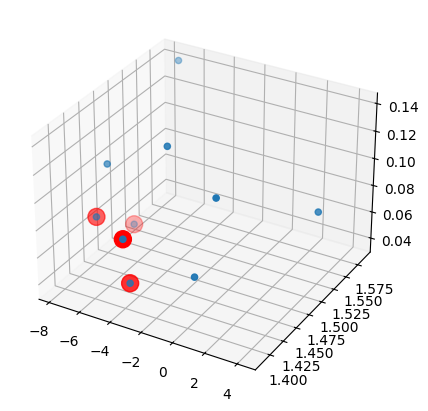

In [9]:
# We do not need all of these indices, since we can reduce our problem to the number each element was picked.
df = groupby.groupby(["allocation_counts"])[["Cumulative Regret (outcome)", "KL Divergence", "Simple Regret With Mean"]].mean()


mask = paretoset(df, sense=["min", "min", "min"])
paretoset_trials = df[mask]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(df["Cumulative Regret (outcome)"], df["KL Divergence"], df["Simple Regret With Mean"])
ax.scatter(paretoset_trials["Cumulative Regret (outcome)"], paretoset_trials["KL Divergence"], paretoset_trials["Simple Regret With Mean"], c="r", s=150)
plt.savefig("mt_resources/4-main/3d-pareto-optimal.pdf", bbox_inches="tight")
plt.show()


In [10]:
df["mask"] = mask

#df  = df.reset_index()

In [11]:
def bold_row(row):
    left, right = "", ""
    if row['mask']:
        left, right = "\\textbf{", "}"
    allocation_counts = json.loads(row['allocation_counts'])
    return  f"{allocation_counts[0] + 1} & {allocation_counts[1] + 1} &{allocation_counts[2] + 1} & " + ' & '.join([left + f"{x:.2f}" + right for x in row[1:4]]) + ' \\\\'

# Apply the bold_row function to each row
bolded_df = df.reset_index().apply(bold_row, axis=1)

# Now, instead of using to_latex, we manually create the table
latex_table = "\\begin{tabular}{l}\n\\toprule\n"
latex_table += "\multicolumn{3}{c}{Intervention Counts} & \multicolumn{3}{c}{}\\\\ \n"
latex_table += "1 & 2 & 3 &Regret & $\KLD$ & \SIR \\\\ \n"
latex_table += "\hline\n"
latex_table += "\n".join(bolded_df)
latex_table += "\n\\bottomrule\n\\end{tabular}"

# Print or save the LaTeX table to a .tex file
print(latex_table)

with open('mt_resources/4-main/pareto.tex', 'w') as f:
    f.write(latex_table)


\begin{tabular}{l}
\toprule
\multicolumn{3}{c}{Intervention Counts} & \multicolumn{3}{c}{}\\ 
1 & 2 & 3 &Regret & $\KLD$ & \SIR \\ 
\hline
1 & 1 &4 & \textbf{-7.80} & \textbf{1.52} & \textbf{0.04} \\
1 & 2 &3 & \textbf{-7.60} & \textbf{1.45} & \textbf{0.07} \\
1 & 3 &2 & -7.38 & 1.46 & 0.10 \\
1 & 4 &1 & -7.20 & 1.59 & 0.14 \\
2 & 1 &3 & \textbf{-3.82} & \textbf{1.40} & \textbf{0.05} \\
2 & 2 &2 & \textbf{-3.59} & \textbf{1.39} & \textbf{0.09} \\
2 & 3 &1 & -3.40 & 1.46 & 0.13 \\
3 & 1 &2 & 0.18 & 1.41 & 0.07 \\
3 & 2 &1 & 0.42 & 1.44 & 0.11 \\
4 & 1 &1 & 4.23 & 1.52 & 0.09 \\
\bottomrule
\end{tabular}


In [12]:
df

,Cumulative Regret (outcome),KL Divergence,Simple Regret With Mean,mask
allocation_counts,,,,
"[0, 0, 3]",-7.795891,1.517331,0.036780,True
"[0, 1, 2]",-7.595006,1.446429,0.068173,True
"[0, 2, 1]",-7.381811,1.461950,0.102767,False
"[0, 3, 0]",-7.203980,1.587368,0.140040,False
"[1, 0, 2]",-3.818454,1.404161,0.047233,True
"[1, 1, 1]",-3.588241,1.387694,0.086407,True
"[1, 2, 0]",-3.395006,1.460771,0.128473,False
"[2, 0, 1]",0.184409,1.407344,0.065033,False
"[2, 1, 0]",0.415430,1.439309,0.111207,False
